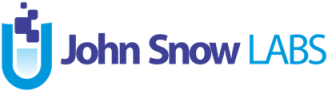

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/tutorials/benchmarks/Benchmarking_Embeddings(Llama_Index+Langtest).ipynb)

**LangTest**is an open-source python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using **John Snow Labs, Hugging Face, Spacy**
models or **OpenAI, Cohere, AI21, Hugging Face Inference API and Azure-OpenAI** based LLMs, it has got you covered. You can test any Named Entity Recognition (NER), Text Classification, fill-mask, Translation model using the library. We also support testing LLMS for Question-Answering, Summarization and text-generation tasks on benchmark datasets. The library supports 50+ out of the box tests. For a complete list of supported test categories, please refer to the [documentation](http://langtest.org/docs/pages/docs/test_categories).

This notebook serves as a comprehensive tool to evaluate different embedding models in a retrieval context, considering various real-world conditions. It employs standard performance metrics and gracefully handles exceptions, allowing for a broad assessment of model capabilities.

In [ ]:
!pip install langtest pandas==2.0.3

In [2]:
import os
os.environ['OPENAI_API_KEY'] = "YOUR API KEY"
os.environ["HUGGINGFACEHUB_API_TOKEN"] = "YOUR API TOKEN"


In [ ]:
!pip install llama-index

In [4]:
import nest_asyncio
nest_asyncio.apply()
from llama_index import VectorStoreIndex
import asyncio
from llama_index import ServiceContext
from llama_index.embeddings import HuggingFaceEmbedding
from llama_index import ServiceContext, set_global_service_context


In [5]:
from langtest.evaluation import LangtestRetrieverEvaluator

In [ ]:
import pickle

# Download the file from GitHub
!wget https://raw.githubusercontent.com/JohnSnowLabs/langtest/main/langtest/data/Retrieval_Datasets/qa_dataset.pkl

# Load the data from the downloaded file
with open('qa_dataset.pkl', 'rb') as file:
    data = pickle.load(file)


In [7]:
documents = data["documents"]
llm = data["llm"]
node_parser = data["node_parser"]
nodes = data["nodes"]
qa_dataset = data["qa_dataset"]

In [8]:
# Define a list of Hugging Face embedding models to be executed.
final_embeddings = ["BAAI/bge-base-en-v1.5",  "infgrad/stella-base-en-v2", "TaylorAI/gte-tiny"]

# Embedding Model Evaluation
It is designed to evaluate the performance of various embedding models from HuggingFace on a retrieval task. Below is an overview of its key components and functionality:

### Key Components and Functionality

1. **Initialization of Embedding Models**:
   - Iterates through `final_embeddings`, a list of embedding model names.
   - Initializes each embedding model using `HuggingFaceEmbedding(i)` and creates a `ServiceContext` for vector operations.



2. **Creating Vector Store Index**:
   - For each embedding model, creates a `VectorStoreIndex`. This structure stores vectors and supports efficient similarity searches.



3. **Setting Up Query Engine and Retriever**:
   - Configures a query engine (`query_engine`) and a retriever (`retriever`).
   - The retriever is set to retrieve the top `similarity_top_k` similar items. In this script, `similarity_top_k=3`, indicating the top three similar nodes are retrieved for each query.



4. **Evaluation Setup**:
   - Initializes an evaluator (`LangtestRetrieverEvaluator`) with specific metrics: Mean Reciprocal Rank (MRR) and Hit Rate.
   - **MRR**: Measures the average of the reciprocal ranks of the first correct answer.
   - **Hit Rate**: Assesses how often the retriever successfully finds a relevant result within the top `k` retrievals.



5. **Applying Perturbations**:
   - Sets up the evaluator to test the retriever's robustness against various perturbations (typos, word swaps, contractions, etc.).



6. **Conducting the Evaluation and Documenting Results**:
   - Evaluates the retriever on a dataset (`qa_dataset`) and prints the results.
   - Saves the results in a CSV file, named after the embedding model.



7. **Error Handling**:
   - Captures and prints exceptions if they occur, adding the problematic embedding model to the `not_supported` list.



In [9]:
import random
random.seed(42)

not_supported=[]
for i in final_embeddings :

  try:

    em = HuggingFaceEmbedding(i)
    servicecontext = ServiceContext.from_defaults(embed_model=em)

    set_global_service_context(servicecontext)

    vector_index = VectorStoreIndex(nodes, servicecontext = servicecontext)

    query_engine = vector_index.as_query_engine()

    retriever = vector_index.as_retriever(similarity_top_k=3)

    retriever_evaluator_HF = LangtestRetrieverEvaluator.from_metric_names(
        ["mrr", "hit_rate"], retriever=retriever
    )

    retriever_evaluator_HF.setPerturbations("add_typo","dyslexia_word_swap", "add_ocr_typo","add_contraction","add_abbreviation",'add_speech_to_text_typo','add_slangs','adjective_synonym_swap')

    # Evaluate
    eval_results = await retriever_evaluator_HF.aevaluate_dataset(qa_dataset)

    print(retriever_evaluator_HF.display_results())

    df = retriever_evaluator_HF.display_results()
    refined_name = i.replace("/", "_")
    save_path = f"{refined_name}.csv"
    df.to_csv(save_path, index=None)

  except Exception as e:

    print(f"{e}")
    not_supported.append(i)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

         Retriever Model                Test Type  Hit Rate       MRR
0  BAAI/bge-base-en-v1.5           original_query  0.775862  0.630747
1  BAAI/bge-base-en-v1.5                 add_typo  0.775862  0.622126
2  BAAI/bge-base-en-v1.5       dyslexia_word_swap  0.758621  0.612069
3  BAAI/bge-base-en-v1.5             add_ocr_typo  0.637931  0.489943
4  BAAI/bge-base-en-v1.5          add_contraction  0.775862  0.630747
5  BAAI/bge-base-en-v1.5         add_abbreviation  0.732759  0.581897
6  BAAI/bge-base-en-v1.5  add_speech_to_text_typo  0.775862  0.614943
7  BAAI/bge-base-en-v1.5               add_slangs  0.767241  0.622126
8  BAAI/bge-base-en-v1.5   adjective_synonym_swap  0.775862  0.609195


config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

             Retriever Model                Test Type  Hit Rate       MRR
0  infgrad/stella-base-en-v2           original_query  0.655172  0.540230
1  infgrad/stella-base-en-v2                 add_typo  0.603448  0.489943
2  infgrad/stella-base-en-v2       dyslexia_word_swap  0.655172  0.524425
3  infgrad/stella-base-en-v2             add_ocr_typo  0.422414  0.329023
4  infgrad/stella-base-en-v2          add_contraction  0.655172  0.534483
5  infgrad/stella-base-en-v2         add_abbreviation  0.534483  0.412356
6  infgrad/stella-base-en-v2  add_speech_to_text_typo  0.620690  0.524425
7  infgrad/stella-base-en-v2               add_slangs  0.637931  0.524425
8  infgrad/stella-base-en-v2   adjective_synonym_swap  0.655172  0.522989


config.json:   0%|          | 0.00/669 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

     Retriever Model                Test Type  Hit Rate       MRR
0  TaylorAI/gte-tiny           original_query  0.724138  0.570402
1  TaylorAI/gte-tiny                 add_typo  0.715517  0.557471
2  TaylorAI/gte-tiny       dyslexia_word_swap  0.715517  0.560345
3  TaylorAI/gte-tiny             add_ocr_typo  0.577586  0.412356
4  TaylorAI/gte-tiny          add_contraction  0.724138  0.563218
5  TaylorAI/gte-tiny         add_abbreviation  0.655172  0.514368
6  TaylorAI/gte-tiny  add_speech_to_text_typo  0.681034  0.538793
7  TaylorAI/gte-tiny               add_slangs  0.724138  0.574713
8  TaylorAI/gte-tiny   adjective_synonym_swap  0.724138  0.548851


# Through Benchmark Embeddings Pipeline

## Checking Single Model

In [10]:
! python -m langtest benchmark embeddings --model TaylorAI/bge-micro --hub huggingface

2024-02-01 07:41:59.912655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 07:41:59.912712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 07:41:59.914432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 07:42:01.031342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Initializing Embedding Model Evaluation with TaylorAI/bge-micro
/usr/local/lib/python3.10/dist-packages/langtest/data/Retrieval_Datasets/qa_dataset.pkl
config.json: 100% 748/748 [00:00<00:00, 3.63MB/s]
pytorch_model.bin: 100% 34.8M/34.8M [00

## Checking Multiple Models

In [11]:
! python -m langtest benchmark embeddings --model "TaylorAI/bge-micro, TaylorAI/gte-tiny" --hub huggingface

2024-02-01 07:42:47.301176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 07:42:47.301218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 07:42:47.302388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 07:42:48.396474: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Initializing Embedding Model Evaluation with TaylorAI/bge-micro
/usr/local/lib/python3.10/dist-packages/langtest/data/Retrieval_Datasets/qa_dataset.pkl
Ready to run evaluation
Running evaluation
      Retriever Model                Test Type